In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(7)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [2]:
class Normalize(nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()
        self.mean = [0.1307]
        self.mean = torch.tensor(self.mean).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
        self.std = [0.3081]
        self.std = torch.tensor(self.std).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
        
    def forward(self, x):
        y = x.clone()
        y.data = (y.data-self.mean) / self.std
        return y

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=256, shuffle=False, **kwargs)

normalize = Normalize()
model = Net().to(device)
model.load_state_dict(torch.load("mnist_cnn.pt"))
model = nn.Sequential(
    normalize,
    model,
)
model.eval()

test(model, device, test_loader)


Test set: Average loss: 0.0315, Accuracy: 9895/10000 (99%)



In [4]:
# RIDE Defense
from advertorch.defenses.base import Processor

class FCN(nn.Module):
    def __init__(self, 
                 input_channels=1,
                 output_channels=1, 
                 kernel_size=3, 
                 channels=16, 
                 bias=True):
        super(FCN, self).__init__()

        self.conv0 = nn.Conv2d(input_channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=bias)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=bias)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=bias)
        self.convn = nn.Conv2d(channels, output_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=bias)

        self.relu = nn.ReLU()

        # initialization
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = F.dropout(x, p=0.5)
        x = self.relu(self.conv2(x))
        x = F.dropout(x, p=0.5)
        x = self.convn(x)

        return torch.sigmoid(x)
    
class Reconstruction(nn.Module):
    def __init__(self, device=torch.device('cuda')):
        super().__init__()
        self.device = device

    def forward(self, input, target, weights=None):
        loss = torch.norm((input-target), 2)
        if weights is not None:
            loss = loss * weights
        loss = loss.sum() / torch.prod(torch.tensor(input.size()).to(self.device))
        return loss
    
def process_output(output, image, ratio1=0.0, ratio2=1.0):
    diff = output - image
    diff_norm = torch.norm(diff, dim=1, p=1).unsqueeze(1).expand(1,1,28,28)
    diff[diff_norm < diff_norm.median()] *= ratio1
    return diff * ratio2

class DefenseRIDE(Processor):

    def __init__(self, net_test):
        super(DefenseRIDE, self).__init__()
        self.net_test = net_test

    def forward(self, x):
        return self._defense_with_ride(x)
    
    def _defense_with_ride(self, image):
        with torch.enable_grad():

            net = FCN()
            net = net.to(device)
            net.train()

            optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), 
                                         eps=1e-08, weight_decay=1e-4, amsgrad=False)
            criterion = Reconstruction()

            for i in range(1001):
                
                net.train()
                weights = torch.rand_like(image[:,0])
                weights = (weights > 0.9).type(torch.float32)
                weights = weights.unsqueeze(1) 

                sigma = 0.1
                additional_noise = torch.randn_like(image).to(device) * sigma
                output = net(image + additional_noise)
                loss = criterion(output, image + 
                                 torch.randn_like(image).to(device) * sigma, weights)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                diff = process_output(output, image, ratio1=0.0, ratio2=0.9)
        
                if i > 100 and i % 200 == 0: 
                    image.data = output.data - diff.data     
                    
        return output

In [5]:
import numpy as np
from skimage.restoration import denoise_tv_chambolle, denoise_tv_bregman
class DefenseTVM(Processor):
    """
    Adversarial Defense with Total Variance Minimization
    """

    def __init__(self, weight):
        super(DefenseTVM, self).__init__()
        self.weight = weight

    def forward(self, x):
        return self._defense_with_tvm(x)
    
    def _defense_with_tvm(self, image):
        img = image.clone()
        img = img.squeeze().detach().cpu().numpy()
        defended = denoise_tv_bregman(img, weight=self.weight)
        defended = defended.astype(np.float32)
        output = torch.from_numpy(defended.copy())
        output = output.unsqueeze(0).unsqueeze(0).to(device)
        return output

In [6]:
from advertorch.defenses import MedianSmoothing2D
from advertorch.defenses import BitSqueezing
from advertorch.defenses import JPEGFilter

bits_squeezing = BitSqueezing(bit_depth=3)
median_filter = MedianSmoothing2D(kernel_size=3)
jpeg_filter = JPEGFilter(10)

def get_defender(mode=3):
    if mode==0:
        defense = nn.Sequential(
            median_filter,
        )

    elif mode==1:
        defense = nn.Sequential(
            bits_squeezing,
        )

    elif mode==2:
        defense_tvm = DefenseTVM(10.0)
        defense = nn.Sequential(
            defense_tvm,
        )

    elif mode==3:
        defense_ride = DefenseRIDE(model)
        defense = nn.Sequential(
            defense_ride,
        )
    return defense

defense = get_defender(mode=3)

In [7]:
num_iter = 10
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow
from advertorch.bpda import BPDAWrapper
from advertorch.attacks import LinfPGDAttack
defense_withbpda = BPDAWrapper(defense, forwardsub=lambda x: x)
defended_model = nn.Sequential(defense_withbpda, model)
bpda_adversary = LinfPGDAttack(
    defended_model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.2,
    nb_iter=num_iter, eps_iter=0.04, rand_init=False, clip_min=0.0, clip_max=1.0,
    targeted=False)

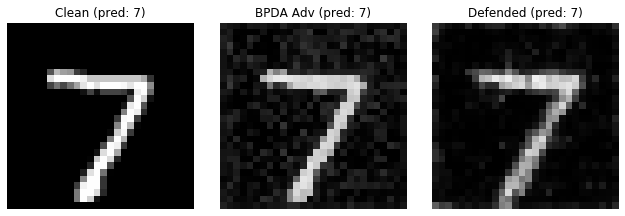

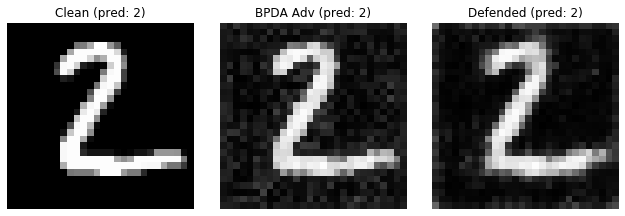

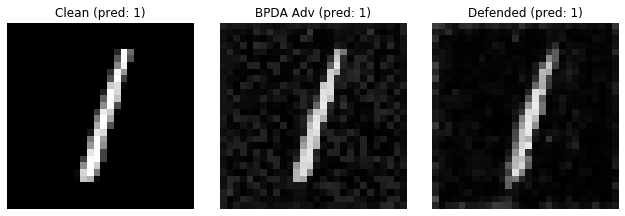

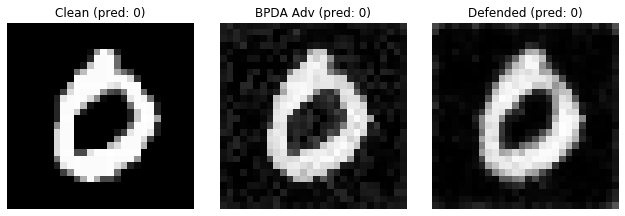

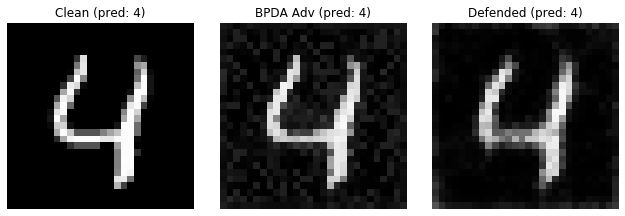

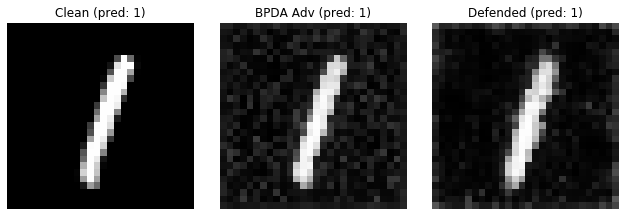

In [9]:
import matplotlib
from matplotlib import pyplot as plt

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1, shuffle=False, **kwargs)

for num, (data, target) in enumerate(test_loader):
    input_data = data.to(device)
    cln_data = input_data.clone()
    true_label = target.to(device)

    bpda_adv = bpda_adversary.perturb(input_data, true_label)
    bpda_adv_defended = defense(bpda_adv)
    
    pred_cln = predict_from_logits(model(cln_data))
    pred_bpda_adv = predict_from_logits(model(bpda_adv))
    pred_bpda_adv_defended = predict_from_logits(model(bpda_adv_defended))

    fig = plt.figure(figsize=(9, 3))
    batch_size = cln_data.size(0)
    for ii in range(batch_size):
        plt.subplot(131)
        _imshow(cln_data[ii])
        plt.title("Clean (pred: {})".format(pred_cln[ii]))
        plt.subplot(132)
        _imshow(bpda_adv[ii])
        plt.title("BPDA Adv (pred: {})".format(
            pred_bpda_adv[ii]))
        plt.subplot(133)
        _imshow(bpda_adv_defended[ii])
        plt.title("Defended (pred: {})".format(
            pred_bpda_adv_defended[ii]))

    plt.tight_layout()
    plt.show()
    
    if num==5: break